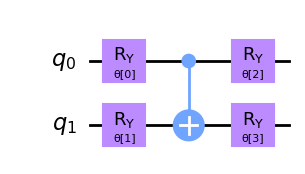

In [1]:
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(num_qubits=2, reps=1, entanglement='linear').decompose()
ansatz.draw(output='mpl')

In [2]:
from qiskit.opflow import Z, I
hamiltonian = Z ^ Z

In [3]:
from qiskit.opflow import StateFn, PauliExpectation
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
pauli_basis = PauliExpectation().convert(expectation)

In [4]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler

quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
                                   # we'll set a seed for reproducibility
                                   shots=8192, seed_simulator=2718,
                                   seed_transpiler=2718)
sampler = CircuitSampler(quantum_instance)

def evaluate_expectation(theta):
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(pauli_basis, params=value_dict).eval()
    return np.real(result)

In [5]:
import numpy as np
point = np.random.random(ansatz.num_parameters)
INDEX = 2

In [6]:
EPS = 0.2
# make identity vector with 1 at INDEX, 0 elsewhere
e_i = np.identity(point.size)[:, INDEX]

plus = point + EPS * e_i
minus = point - EPS * e_i

finite_difference = (evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * EPS)
print(finite_difference)

0.08605957031249986


In [7]:
from qiskit.opflow import Gradient

shifter = Gradient('fin_diff', analytic=False, epsilon=EPS)
grad = shifter.convert(expectation, params=ansatz.parameters[INDEX])
print(grad)

value_dict = dict(zip(ansatz.parameters, point))
sampler.convert(grad, params=value_dict).eval().real

SummedOp([
  2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] + 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ]),
  -2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] - 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ])
])


0.0421142578125

In [8]:
EPS = np.pi / 2
e_i = np.identity(point.size)[:, INDEX]

plus = point + EPS * e_i
minus = point - EPS * e_i

finite_difference = (evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * EPS)

print(finite_difference)

0.043285792628020396


In [9]:
shifter = Gradient() # parameter-shift by default
grad = shifter.convert(expectation, params=ansatz.parameters[INDEX])
sampler.convert(grad, params=value_dict).eval().real

0.06213378906250008

In [10]:
# initial_point = np.random.random(ansatz.num_parameters)
initial_point = np.array([0.43253681, 0.09507794, 0.42805949, 0.34210341])

In [11]:
gradient = Gradient().convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(quantum_instance)

def evaluate_gradient(theta):
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(gradient_in_pauli_basis, params=value_dict).eval()
    return np.real(result)

In [12]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.loss = []
    def update(self, _nfevs, _theta, ftheta, *_):
        """Save intermediate results. Optimizers pass many values
        but we only store the third."""
        self.loss.append(ftheta)
        
from qiskit.algorithms.optimizers import GradientDescent
gd_log = OptimizerLog()
gd = GradientDescent(maxiter=300, learning_rate=0.01, callback=gd_log.update)

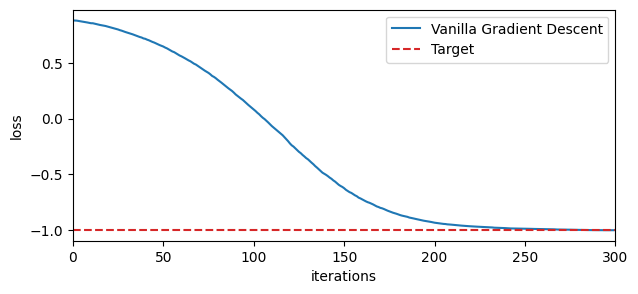

In [13]:
result = gd.minimize(
    fun=evaluate_expectation, # function to minimize
    x0=initial_point, # initial point
    jac=evaluate_gradient, # function to evaluate gradient
)

import matplotlib.pyplot as plt
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, label='Vanilla Gradient Descent')
plt.axhline(-1, ls='--', c='C3', label='Target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.xlim(0, 300)
plt.legend();

In [14]:
from qiskit.opflow import NaturalGradient

In [15]:
natural_gradient = (NaturalGradient(regularization='ridge').convert(expectation))
natural_gradient_in_pauli_basis = PauliExpectation().convert(natural_gradient)
sampler = CircuitSampler(quantum_instance, caching='all')

def evaluate_natural_gradient(theta):
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(natural_gradient_in_pauli_basis, params=value_dict).eval()
    return np.real(result)

print('Vanilla gradient:', evaluate_gradient(initial_point))
print('Natural gradient:', evaluate_natural_gradient(initial_point))

Vanilla gradient: [ 0.13989258 -0.35095215 -0.25402832 -0.22497559]
Natural gradient: [ 0.75511361 -0.87788002 -0.99746401 -0.34407584]


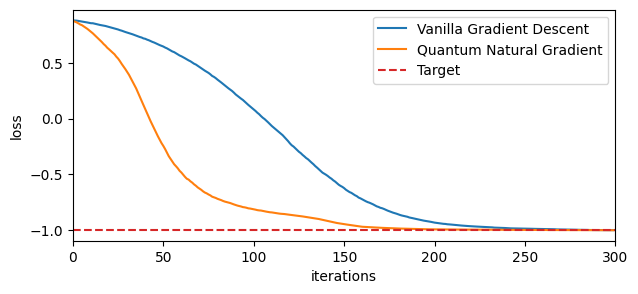

In [16]:
qng_log = OptimizerLog()
qng = GradientDescent(maxiter=300, learning_rate=0.01, callback=qng_log.update)
result = qng.minimize(evaluate_expectation, initial_point, evaluate_natural_gradient)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='Vanilla Gradient Descent')
plt.plot(qng_log.loss, 'C1', label='Quantum Natural Gradient')
plt.axhline(-1, ls='--', c='C3', label='Target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.xlim(0, 300)
plt.legend();

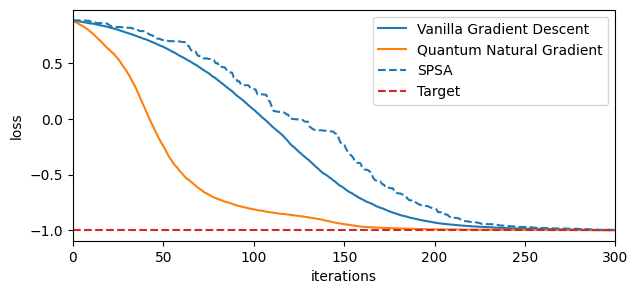

In [17]:
from qiskit.algorithms.optimizers import SPSA
spsa_log = OptimizerLog()
spsa = SPSA(maxiter=300, learning_rate=0.01, perturbation=0.01, callback=spsa_log.update)

result = spsa.minimize(evaluate_expectation, initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='Vanilla Gradient Descent')
plt.plot(qng_log.loss, 'C1', label='Quantum Natural Gradient')
plt.plot(spsa_log.loss, 'C0', ls='--', label='SPSA')
plt.axhline(-1, ls='--', c='C3', label='Target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.xlim(0, 300)
plt.legend();

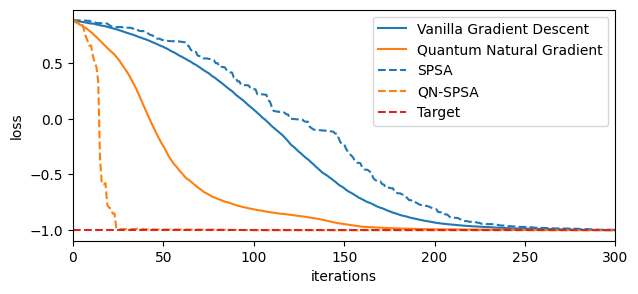

In [19]:
from qiskit.algorithms.optimizers import QNSPSA
qnspsa_log = OptimizerLog()
fidelity = QNSPSA.get_fidelity(ansatz, quantum_instance, expectation=PauliExpectation())
qnspsa = QNSPSA(fidelity, maxiter=300, learning_rate=0.01, perturbation=0.01, callback=qnspsa_log.update)

result = qnspsa.minimize(evaluate_expectation, initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='Vanilla Gradient Descent')
plt.plot(qng_log.loss, 'C1', label='Quantum Natural Gradient')
plt.plot(spsa_log.loss, 'C0', ls='--', label='SPSA')
plt.plot(qnspsa_log.loss, 'C1', ls='--', label='QN-SPSA')
plt.axhline(-1, ls='--', c='C3', label='Target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.xlim(0, 300)
plt.legend();

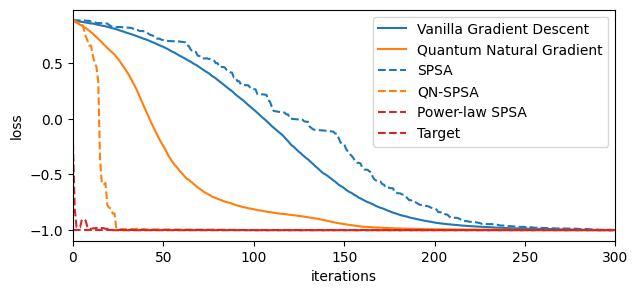

In [20]:
autospsa_log = OptimizerLog()
autospsa = SPSA(maxiter=300, learning_rate=None, perturbation=None, callback=autospsa_log.update)

result = autospsa.minimize(evaluate_expectation, initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='Vanilla Gradient Descent')
plt.plot(qng_log.loss, 'C1', label='Quantum Natural Gradient')
plt.plot(spsa_log.loss, 'C0', ls='--', label='SPSA')
plt.plot(qnspsa_log.loss, 'C1', ls='--', label='QN-SPSA')
plt.plot(autospsa_log.loss, 'C3', ls='--', label='Power-law SPSA')
plt.axhline(-1, ls='--', c='C3', label='Target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.xlim(0, 300)
plt.legend();

In [23]:
from qiskit.opflow import I

def sample_gradients(num_qubits, reps, local=False):
    """Sample the gradient of our model for ``num_qubits`` qubits and
    ``reps`` repetitions.

    We sample 100 times for random parameters and compute the gradient
    of the first RY rotation gate.
    """
    index = num_qubits - 1
    
    # local or global operator
    if local:
        operator = Z ^ Z ^ (I ^ (num_qubits - 2))
    else:
        operator = Z ^ num_qubits
        
    # real amplitude ansatz
    ansatz = RealAmplitudes(num_qubits, reps=reps, entanglement='linear')
    
    # construct Gradient we wnat to evaluate for different values
    expectation = StateFn(operator, is_measurement=True).compose(StateFn(ansatz))
    grad = Gradient().convert(expectation, params=ansatz.parameters[index])
    
    # evaluate for 100 different random parameters
    num_points = 100
    grads = []
    for _ in range(num_points):
        # points are uniformly distributed in [0, pi]
        point = np.random.uniform(0, np.pi, ansatz.num_parameters)
        value_dict = dict(zip(ansatz.parameters, point))
        grads.append(sampler.convert(grad, value_dict).eval())
        
    return grads

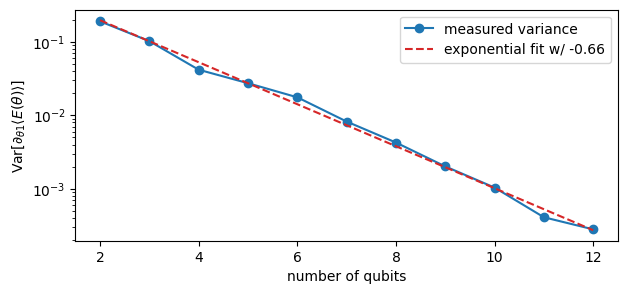

In [24]:
num_qubits = list(range(2, 13))
reps = num_qubits # number of layers = number of qubits
gradients = [sample_gradients(n, r) for n, r in zip(num_qubits, reps)]

fit = np.polyfit(num_qubits, np.log(np.var(gradients, axis = 1)), deg = 1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits, np.var(gradients, axis = 1), 'o-', label='measured variance')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]),'--', c='C3', label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1}\langle E(\theta)\rangle]$')
plt.legend(loc='best');